### Import Libraries

In [1]:
from wrapper_functions import *

C:\Users\Admin-Dell\Documents\github_projects\pop_ensemble\code\wrapper_functions.py:1250: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if kernel_type is 'hmc':
C:\Users\Admin-Dell\Documents\github_projects\pop_ensemble\code\wrapper_functions.py:1257: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if kernel_type is 'hmc':
C:\Users\Admin-Dell\Documents\github_projects\pop_ensemble\code\wrapper_functions.py:1273: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if step_adaptor_type is 'simple':
C:\Users\Admin-Dell\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
C:\Users\Admin-Dell\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimenta

TensorFlow version: 2.11.0. Expected: 2.7.0
TensorFlow Probability version: 0.19.0. Expected: 0.15.0


### Read in Data

In [2]:
#training2010 = pd.read_csv('../data/merged_wp_census_data_280922.csv')
training2010 = pd.read_csv('../data/merged_wp_census_data2_081122.csv')
county_adj = pd.read_csv('../data/countyadj2.csv', index_col = 0)
models = ['acs', 'pep', 'worldpop']

In [3]:
data_NY, adj_NY = subset_data_by_state(training2010, county_adj, 'New York', 'NY')

data_GA, adj_GA = subset_data_by_state(training2010, county_adj, 'Georgia', 'GA')

In [4]:
data_GA

,GEOID,NAME,acs,census,pep,lon,lat,worldpop
357,13001,"Appling County, Georgia",18050,18236,18334,-82.310258,31.744120,18252.248366
358,13003,"Atkinson County, Georgia",8332,8375,8364,-82.900324,31.277997,8280.643018
359,13005,"Bacon County, Georgia",10969,11096,11062,-82.479974,31.543162,11092.873979
360,13007,"Baker County, Georgia",3657,3451,3431,-84.465345,31.310185,3476.480121
361,13009,"Baldwin County, Georgia",46905,45720,45704,-83.254069,33.068964,45423.391449
...,...,...,...,...,...,...,...,...
511,13313,"Whitfield County, Georgia",99910,102599,102745,-84.971605,34.796990,102848.123472
512,13315,"Wilcox County, Georgia",9041,9255,9314,-83.470904,31.969460,9207.866530
513,13317,"Wilkes County, Georgia",10580,10593,10388,-82.755558,33.783775,10579.815508
514,13319,"Wilkinson County, Georgia",9685,9563,9529,-83.194991,32.801053,9687.102703


# Default Configs

In [5]:
# MCMC configs.
mcmc_step_size=0.1 # @param
mcmc_sample_size=500 # @param
mcmc_num_steps=10_000 # @param
mcmc_burnin=2_500 # @param
mcmc_nchain=10 # @param
mcmc_seed=0 # @param

DEFAULT_MCMC_CONFIG = dict(step_size=mcmc_step_size, 
                           num_steps=mcmc_sample_size, 
                           burnin=mcmc_burnin, 
                           nchain=mcmc_nchain, 
                           seed=mcmc_seed)

In [17]:
tau2 = 1
rho = 0.3
print('fixing tau2 and rho')

adjacency = adj_NY
data = data_NY
nchain = 5

Q = (1/tau2)*(np.diag(adjacency.sum(axis=1)) - rho*adjacency)
Q = tf.constant(Q, dtype = tf.float32)
init_state = tf.constant(np.array([mv_normal_sample(precision_matrix = Q, num_models = 3) for i in range(nchain)]),
                       dtype = tf.float32)

# define log likelihood function
def target_log_prob_fn_CAR(phi):
    #Q = (1/tau2)*(np.diag(adjacency.sum(axis=1)) - rho*adjacency)
    #Q = tf.constant(Q, dtype = tf.float32)

    ll = tf.Variable(0.)
    for chain in range(phi.shape[0]):
        # (1) Prob of the CAR random effect values
        ll_chain = -0.5*tf.reduce_mean(tf.linalg.diag_part(
            tf.linalg.matmul(phi[chain,:,:],tf.linalg.matmul(Q, phi[chain,:,:]), transpose_a = True))) 
        ll = ll + ll_chain

    # add in determinant values
    log_det = tf.constant(np.linalg.slogdet(Q)[1], dtype = tf.float32)
    #log_det = tf.linalg.logdet(Q)[1], dtype = tf.float32
    ll = ll + 0.5*phi.shape[0]*len(models)*log_det

    # get exponentiated values and sum across models
    exp_phi = tf.math.exp(phi)
    exp_phi_rows = tf.reduce_sum(exp_phi, 2)

    # get model weights and calculate mean estimate
    u = exp_phi/exp_phi_rows[...,None]

    tmp = data[models].values*u
    n = tf.reduce_sum(tmp, axis = 2)

    # update the log likelihood 
    ll = ll + tf.reduce_sum([np.sum(data['census']*np.log(n[chain,:]) - n[chain,:]) for chain in range(phi.shape[0])])

    return(ll)      

phi = tf.Variable(initial_value = init_state)
def loss():
    return - target_log_prob_fn_CAR(phi)

opt = tf.keras.optimizers.Adam(learning_rate=0.1)

target_log_prob_fn_CAR(phi)

for iter in range(20_000):
    if iter % 1_000 == 0:
      print(phi[0,0,0])
      print(f'{loss().numpy()}...', end='')
      _ = opt.minimize(loss, [phi])
      print(phi[0,0,0])

fixing tau2 and rho


## Bayesian Model Averaging

A Bayesian ensemble model where ensemble weights $w_k's$ are parameterized by Gaussian process priors:

$y \sim N(\mu(x), \sigma^2)$ 

$\mu(x) = \sum_{k=1}^K w_k(x) * m_k(x) \quad$  where $\{m_k\}_{k=1}^K$ are base model predictions.

$w(x) = softmax(f(x)) \qquad\;\;\;$ where $w=[w_1, \dots, w_K]$ and $f=[f_1, \dots, f_K]$

$f \stackrel{i.i.d.}{\sim} GaussianProcess(0, k)$


### Run MCMC

Seems like this takes ~2.6s per num_steps
Took 265s for num_steps = 100
Took 51s for num_steps = 50
102s for num_steps = 100
262s for num_steps = 100 test
12s for num_steps = 100 the improved test
and 16m for num_steps = 10000 and nchain = 5! Great. \\

I think this was before I re-computed the Q determinant every time. With that, it takes 5 hours for 10000 steps and nchain = 5 (or 10?) So ya, it's slow. I can't imagine what this will be like for the entire US. However, that could have been because of bad sleep settings on my comp, so we might be a-ok here

For NY (n = 62) nuts, nchain = 2, num_steps = 100, 10m \
For GA (n = 159) nuts, nchain = 2, num_steps = 100, 230s...? Maybe because of the 6% acceptance? \
For US (n = 3064) nuts, nchain = 2, num_steps = 100, 482s. So not linear time! Yay \
For US (n = 3064) nuts, nchain = 5, num_steps = 1000, 4 hours (unfortunately I forgot to do burnin, but oh well)\
For US (n = 3064) hmc, nchain = 5, num_steps = 1000, 6 hours (but is that because I included the burnin? Maybe)

Testing the step size adapters

#### Running with HMC

In [7]:
mcmc_config = DEFAULT_MCMC_CONFIG.copy()
mcmc_config.update(dict(burnin = 250, num_steps = 1000, nchain = 2, kernel_type = 'hmc', step_adaptor_type = 'simple'))
mcmc_config

{'step_size': 0.1,
 'num_steps': 1000,
 'burnin': 250,
 'nchain': 2,
 'seed': 0,
 'kernel_type': 'hmc',
 'step_adaptor_type': 'simple'}

In [8]:
t0 = time.perf_counter()
CAR_samples5, chain_samples5, sampler_stat5 = run_mcmc_CAR(data = data_NY,
                                                        adjacency = adj_NY,
                                                        models = models,
                                                        debug_mode = True,
                                                        **mcmc_config)  
print(time.perf_counter() - t0)

fixing tau2 and rho


NotImplementedError: in user code:

    File "C:\Users\Admin-Dell\Documents\github_projects\pop_ensemble\code\wrapper_functions.py", line 2001, in loss  *
        nll = -target_log_prob_fn(phi)
    File "C:\Users\Admin-Dell\Documents\github_projects\pop_ensemble\code\wrapper_functions.py", line 2058, in target_log_prob_fn_CAR  *
        ll = ll + tf.reduce_sum([np.sum(data['census']*np.log(n[chain,:]) - n[chain,:]) for chain in range(phi.shape[0])])

    NotImplementedError: Cannot convert a symbolic tf.Tensor (strided_slice_5:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [14]:
print(tfp.mcmc.effective_sample_size(chain_samples5, cross_chain_dims = 1).numpy().mean())
tfp.mcmc.effective_sample_size(chain_samples5, cross_chain_dims = 1)

5.0249867


<tf.Tensor: shape=(62, 3), dtype=float32, numpy=
array([[ 3.1139355,  2.990702 ,  6.719871 ],
       [ 3.6502035,  3.0585093,  2.8912413],
       [ 2.9860353,  6.3388014,  2.3612192],
       [10.034446 ,  2.2131934,  2.0258803],
       [ 2.152844 ,  2.3796098,  3.497998 ],
       [ 3.9946604,  4.895562 ,  6.627333 ],
       [ 2.2121418,  2.2263203,  2.3669565],
       [15.473498 , 13.529883 ,  3.0239065],
       [ 9.23467  ,  5.3665924,  2.182166 ],
       [ 2.8611488,  4.023483 ,  2.1916919],
       [ 7.127136 ,  2.430232 ,  3.203261 ],
       [ 3.2640886,  9.282577 ,  2.647546 ],
       [ 2.5643609,  7.707972 ,  8.082012 ],
       [ 2.5549874,  2.463151 ,  2.747322 ],
       [ 4.9483123, 10.384684 , 10.655391 ],
       [ 9.507161 ,  3.8494098,  2.80026  ],
       [ 7.121102 ,  7.554476 ,  6.730869 ],
       [ 2.0998962,  2.346736 ,  2.3504128],
       [ 4.1875224,  6.845904 ,  3.3153322],
       [ 2.6538174,  6.1125975,  4.1511025],
       [ 5.0331955, 14.463224 ,  3.2406754],
      

In [9]:

mcmc_config.update(dict(burnin = 0, num_steps = 1100, nchain = 2, kernel_type = 'hmc', step_adaptor_type = 'simple'))
mcmc_config

{'step_size': 0.1,
 'num_steps': 1100,
 'burnin': 0,
 'nchain': 2,
 'seed': 0,
 'kernel_type': 'hmc',
 'step_adaptor_type': 'simple'}

In [10]:
t0 = time.perf_counter()
CAR_samples1, chain_samples1, sampler_stat1 = run_mcmc_CAR(data = data_NY,
                                                        adjacency = adj_NY,
                                                        models = models,
                                                        debug_mode = True,
                                                        **mcmc_config)  
print(time.perf_counter() - t0)

fixing tau2 and rho
kernel type is hmc
simple step size
1100
<function run_chain_CAR.<locals>.trace_fn at 0x000002287A985E50>
no cache clearing
Acceptance Ratio: 0.34286341071128845
52.61782019999998


In [11]:
sampler_stat1

(<tf.Tensor: shape=(1100,), dtype=float32, numpy=
 array([0.1       , 0.0990099 , 0.09802961, ..., 0.0199498 , 0.0199498 ,
        0.0199498 ], dtype=float32)>,
 <tf.Tensor: shape=(1100,), dtype=float32, numpy=
 array([-6.3840424e+01, -3.1454773e+01, -3.2388046e+01, ...,
        -4.6310425e-02, -6.3879868e+01, -6.3866180e+01], dtype=float32)>)

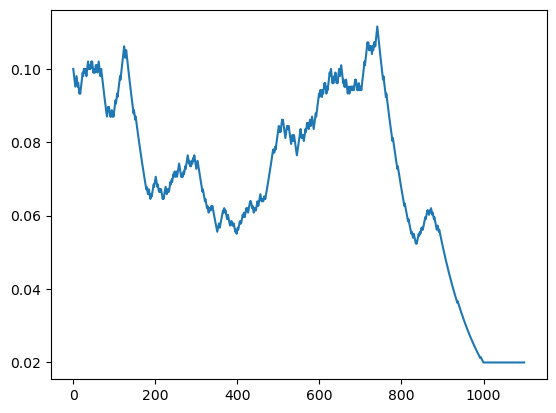

In [19]:
plt.plot(range(1100), sampler_stat1[0].numpy())

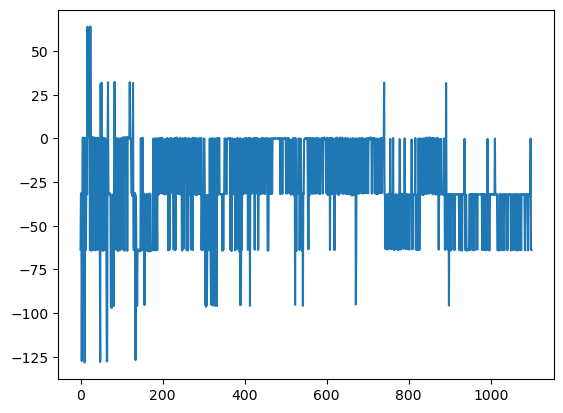

In [20]:
plt.plot(range(1100), sampler_stat1[1].numpy())

In [ ]:
mcmc_config.update(dict(burnin = 2500, num_steps = 1000, nchain = 2, kernel_type = 'hmc'))
mcmc_config

In [ ]:
t0 = time.perf_counter()
CAR_samples2, chain_samples2, sampler_stat2 = run_mcmc_CAR(data = data_NY,
                                                        adjacency = adj_NY,
                                                        models = models,
                                                        debug_mode = True,
                                                        **mcmc_config)  
print(time.perf_counter() - t0)

In [ ]:
mcmc_config.update(dict(burnin = 250, num_steps = 1000, nchain = 2, kernel_type = 'hmc', step_adaptor_type = 'dual_averaging'))
mcmc_config

In [ ]:
t0 = time.perf_counter()
CAR_samples3, chain_samples3, sampler_stat3 = run_mcmc_CAR(data = data_NY,
                                                        adjacency = adj_NY,
                                                        models = models,
                                                        debug_mode = True,
                                                        **mcmc_config)  
print(time.perf_counter() - t0)

In [ ]:
mcmc_config.update(dict(burnin = 2500, num_steps = 1000, nchain = 2, kernel_type = 'hmc', step_adaptor_type = 'dual_averaging'))
mcmc_config

In [ ]:
t0 = time.perf_counter()
CAR_samples4, chain_samples4, sampler_stat4 = run_mcmc_CAR(data = data_NY,
                                                        adjacency = adj_NY,
                                                        models = models,
                                                        debug_mode = True,
                                                        **mcmc_config)  
print(time.perf_counter() - t0)

In [ ]:
print(sampler_stat1[0].numpy().mean())
print(sampler_stat2[0].numpy().mean())
print(sampler_stat3[0].numpy().mean())
print(sampler_stat4[0].numpy().mean())

In [ ]:
chain_samples3[:,0,1,1]

In [ ]:
t0 = time.perf_counter()
CAR_samples, chain_samples, sampler_stat = run_mcmc_CAR(data = training2010,
                                                        adjacency = county_adj,
                                                        models = models,
                                                        debug_mode = True,
                                                        **mcmc_config)  
print(time.perf_counter() - t0)

Saving and loading Python objects with Pickle

In [ ]:
print(tfp.mcmc.effective_sample_size(chain_samples, cross_chain_dims = 1).numpy().mean())
print(tfp.mcmc.potential_scale_reduction(chain_samples, independent_chain_ndims=1).numpy().mean())

In [ ]:
import pickle

# using local data file because these are too big for github
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
with open(local_dir + 'CAR_samples_fullUS_n10000_hmc_Jan132023.pickle', 'wb') as results_file:
  pickle.dump([CAR_samples, chain_samples, sampler_stat], results_file)

#### Running with NUTS

In [ ]:
mcmc_config.update(dict(kernel_type = 'nuts'))
mcmc_config

In [ ]:
t0 = time.perf_counter()
CAR_samples2, chain_samples2, sampler_stat2 = run_mcmc_CAR(data = training2010,
                                                        adjacency = county_adj,
                                                        models = models,
                                                        debug_mode = True,
                                                        **mcmc_config)  
print(time.perf_counter() - t0)

In [ ]:
# using local data file because these are too big for github
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
with open(local_dir + 'CAR_samples_fullUS_n10000_nuts_Jan132023.pickle', 'wb') as results_file:
  pickle.dump([CAR_samples2, chain_samples2, sampler_stat2], results_file)

### Loading results and analyzing

In [ ]:
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
file = local_dir + 'CAR_samples_fullUS_n10000_nuts_Jan132023.pickle'
with open(file, "rb") as input_file:
     CAR_samples, chain_samples, sampler_stat = pickle.load(input_file)

In [ ]:
chain_samples.shape

In [ ]:
ESS = tfp.mcmc.effective_sample_size(chain_samples, cross_chain_dims = 1)

In [ ]:
ESS.numpy().mean()

In [ ]:
rhat = tfp.mcmc.potential_scale_reduction(chain_samples)

In [ ]:
rhat.numpy().mean()

In [ ]:
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
file = local_dir + 'CAR_samples_fullUS_n10000_hmc_Jan132023.pickle'
with open(file, "rb") as input_file:
     CAR_samples2, chain_samples2, sampler_stat2 = pickle.load(input_file)

In [ ]:
ESS_hmc = tfp.mcmc.effective_sample_size(chain_samples2, cross_chain_dims = 1)

In [ ]:
ESS_hmc.numpy().mean()

In [ ]:
rhat_hmc = tfp.mcmc.potential_scale_reduction(chain_samples2)

In [ ]:
rhat_hmc.numpy().mean()

In [ ]:
chain_samples.shape

In [ ]:
chain_pull = chain_samples[:,0,0,0]
n, bins, patches = plt.hist(x = chain_pull, bins = 'auto')

In [ ]:
chain_pull = chain_samples[:,1,0,0]
n, bins, patches = plt.hist(x = chain_pull, bins = 'auto')

In [ ]:
sampler_stat

In [ ]:
sampler_stat2

In [ ]:
print(tfp.mcmc.effective_sample_size(chain_samples2, cross_chain_dims = 1).numpy().mean())
print(tfp.mcmc.potential_scale_reduction(chain_samples2).numpy().mean())

In [ ]:
CAR_ensemble_weights = tf.reduce_mean(CAR_samples[0], axis = 2)

weights_dict = {
    "acs": CAR_ensemble_weights[:,0],
    "pep": CAR_ensemble_weights[:,1],
    "worldpop": CAR_ensemble_weights[:,2]
}

color_weights = make_color_norm(
    list(weights_dict.values())[1],   
    method="percentile")

In [ ]:
# get exponentiated values and sum across models
exp_phi = tf.math.exp(CAR_ensemble_weights)
exp_phi_rows = tf.reduce_sum(exp_phi, 1)

# get model weights and calculate mean estimate
u = exp_phi/exp_phi_rows[...,None]


In [ ]:
norm_weights_dict = {
    "acs": u[:,0],
    "pep": u[:,1],
    "worldpop": u[:,2]
}

color_norm_weights = make_color_norm(
    list(norm_weights_dict.values())[1],   
    method="percentile")

In [ ]:
import plotly
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
# df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
#                    dtype={"fips": str})
import matplotlib.colors as colors

import plotly.express as px

In [ ]:
for model_name in models:
    output = pd.DataFrame(np.column_stack([training2010[["GEOID"]], weights_dict[model_name]]))
    output = output.set_axis(['GEOID', model_name], axis=1)
    output[model_name] = output[model_name].astype(float)
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [ ]:
for model_name in models:
    output = pd.DataFrame(np.column_stack([training2010[["GEOID"]], norm_weights_dict[model_name]]))
    output = output.set_axis(['GEOID', model_name], axis=1)
    output[model_name] = output[model_name].astype(float)
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()